In [1]:
import hashlib
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pylab as plt
import copy

import importlib

%load_ext autoreload
%autoreload 2

def hash_id(worker_id):
    return 'W' + hashlib.md5(worker_id.encode()).hexdigest()[:10]

In [2]:
# Set experiment: this can be 2 or 3
experiment = 2
read_data_path = "experiment/raw-exp-data/exp{}/".format(experiment) 
write_data_path = "experiment/"

# Loading Data
## Read participant info from questions

In [3]:
questions = pd.read_csv(read_data_path + "questiondata.csv")


In [ ]:
def get_objective_from_string(json_string):
    
    results_dict = json.loads(json_string)
    return results_dict.get("objective", "unknown")
    
def get_trial_type_from_string(json_string):

    results_dict = json.loads(json_string)
    return results_dict.get("trial_type", "unknown")
    
def get_horizon_from_string(json_string):

    results_dict = json.loads(json_string)
    return results_dict.get("horizon", "unknown")

    
conditions = questions[questions.key == 'condition']
conditions["objective"] = conditions["value"].apply(lambda x: get_objective_from_string(x))
conditions["horizon"] = conditions["value"].apply(lambda x: get_horizon_from_string(x))
conditions["message_type"] = conditions["value"].apply(lambda x: get_trial_type_from_string(x))

participant_objectives = conditions.set_index("workerid")[["message_type", "objective", "horizon"]]

In [5]:
participant_objectives.groupby(["message_type", "objective", "horizon"]).size()

message_type  objective  horizon  
slider        ambiguous  ambiguous    100
              belief     ambiguous    102
              utility    ambiguous     98
dtype: int64

In [6]:
participant_objectives["message_type"].value_counts()

slider    300
Name: message_type, dtype: int64

In [7]:
# Verify all randomizations

if True:
    print("\nLog message counts:")
    print(questions.key.value_counts())
    
    print("\nFull condition messages:")
    print(questions[questions.key == "condition"].value.value_counts())
    
    print("\nTrial data files used:")
    print(questions[questions.key == "trialDataFile"].value.value_counts())

    print("\nFeature randomizations:")
    feature_randomizations = questions[questions.key == "featureRandomization"].value
    feature_randomizations = feature_randomizations.apply(lambda x: json.loads(x))
    feature_randomizations = pd.DataFrame(list(feature_randomizations.values))
    for feature in ["Green", "Red", "Blue", "Spotted", "Solid", "Striped"]:
        print(feature_randomizations[feature].value_counts())


Log message counts:
startTime               350
condition               300
trialDataFile           300
featureRandomization    300
quizAttempt-1           300
quizPassed              275
bonus                   275
quizAttempt-2           138
quizAttempt-3            50
quizFailed               26
Name: key, dtype: int64

Full condition messages:
{"objective":"belief","trial_type":"slider","horizon":"ambiguous"}       102
{"objective":"ambiguous","trial_type":"slider","horizon":"ambiguous"}    100
{"objective":"utility","trial_type":"slider","horizon":"ambiguous"}       98
Name: value, dtype: int64

Trial data files used:
exp2_split1    83
exp2_split2    76
exp2_split3    74
exp2_split4    67
Name: value, dtype: int64

Feature randomizations:
Green      59
Striped    51
Solid      50
Blue       49
Red        48
Spotted    43
Name: Green, dtype: int64
Blue       57
Red        54
Spotted    50
Solid      49
Green      45
Striped    45
Name: Red, dtype: int64
Red        54
Green      52

## Read in trial data

In [8]:
from datetime import datetime

trials = pd.read_csv(read_data_path + "trialdata.csv")

trials.head()

,Unnamed: 0,workerid,num,ts,value
0,0,Wcd24be75b9,0,1650048828261,"{""rt"": 7273, ""stimulus"": ""<img src=\""/static/i..."
1,1,Wcd24be75b9,1,1650048983286,"{""view_history"": [{""page_index"": 0, ""viewing_t..."
2,2,Wcd24be75b9,2,1650049007422,"{""rt"": 24127, ""response"": {""tour-guide-job"": ""..."
3,3,Wcd24be75b9,3,1650049010695,"{""rt"": 3266, ""stimulus"": ""<br>3/3 questions co..."
4,4,Wcd24be75b9,4,1650049022934,"{""rt"": 12233, ""response"": {""Blue"": 1, ""Red"": 2..."


In [9]:
# Read JSON data into Python objects
trials["data"] = trials.value.apply(lambda x: json.loads(x))

for field in ["rt", "trial_type"]:
    trials[field] = trials.data.apply(lambda x: x.get(field))
    
trials.trial_type.value_counts()
trials = trials.set_index("workerid").join(participant_objectives, how="left").reset_index()

In [10]:
print(trials.groupby("objective").workerid.nunique())

objective
ambiguous    100
belief       102
utility       98
Name: workerid, dtype: int64


In [11]:
print("Pre-Quiz Counts")
trials.groupby("message_type").workerid.nunique()

Pre-Quiz Counts


message_type
slider    300
Name: workerid, dtype: int64

In [ ]:
exit = trials[trials.trial_type == 'survey-text']
exit.groupby("message_type").workerid.nunique()

for question in ["experiment_objective", "participant_strategy", "experiment_confusing", "misc_feedback"]:
    exit[question] = exit.data.apply(lambda x: x["response"][question])

if False:
    for k, g in exit.groupby(["objective", "horizon"]):

        print("\n         ====== {} ======\n".format(k))

        print("Experiment Objective:\n")
        print(g.experiment_objective.values)

        print("\nParticipant Strategies:\n")
        print(g.participant_strategy.values)

        print("\nAnything Confusing:\n")
        print(g.experiment_confusing.values)

        print("\nMisc Feedback:\n")
        print(g.misc_feedback.values)

# Sanity Checks

##  Instructions
How long do people take in instructions? 

Text(0.5, 0.98, 'Minutes Spent in Instructions')

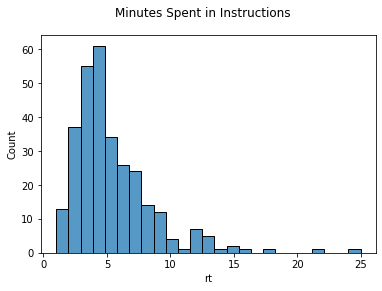

In [13]:
instructions = trials[trials.trial_type == 'instructions']
total_minutes_in_instructions = instructions.groupby("workerid").rt.sum() / 1000 / 60
sns.histplot(total_minutes_in_instructions)
plt.suptitle("Minutes Spent in Instructions")
# total_minutes_in_instructions.describe()

count    300.000000
mean      16.473460
std        6.836244
min        2.832317
25%       11.894312
50%       14.872050
75%       19.581833
max       45.315533
Name: time_elapsed, dtype: float64

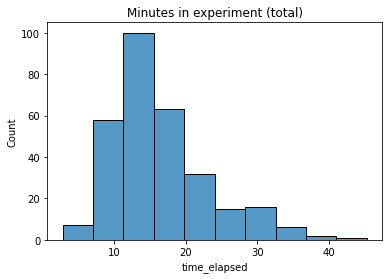

In [14]:
trials["time_elapsed"] = trials.data.apply(lambda x: x.get("time_elapsed"))
minutes_in_experiment = trials.groupby("workerid").time_elapsed.max() / 1000 / 60

sns.histplot(minutes_in_experiment, bins=10)
plt.title("Minutes in experiment (total)")

# print("Median: {:.2f}".format(minutes_in_experiment.median()))
# print("Mean: {:.2f}".format(minutes_in_experiment.mean()))
# print("75th percentile: {:.2f}".format(minutes_in_experiment.quantile(.75)))

minutes_in_experiment.describe()

## Quiz

In [18]:
pass_or_fail = questions[questions.key.isin(["quizPassed", "quizFailed"])]
pass_or_fail.key.value_counts()

quizPassed    275
quizFailed     26
Name: key, dtype: int64

In [19]:
pass_or_fail['passed_quiz'] = pass_or_fail.key.apply(lambda x: True if x == 'quizPassed' else False)
pass_or_fail = pass_or_fail[['workerid', 'passed_quiz']]

conditions_and_quiz = pd.merge(participant_objectives.reset_index(), pass_or_fail, left_on='workerid', right_on='workerid')

conditions_and_quiz.groupby(['message_type', 'objective', 'horizon', 'passed_quiz']).size()

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_30928/3466410020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_or_fail['passed_quiz'] = pass_or_fail.key.apply(lambda x: True if x == 'quizPassed' else False)


message_type  objective  horizon    passed_quiz
slider        ambiguous  ambiguous  False          11
                                    True           89
              belief     ambiguous  False           9
                                    True           94
              utility    ambiguous  False           6
                                    True           92
dtype: int64

In [20]:
## Additional info on quiz.
quizAttempts = questions[questions.key.str.contains('quizAttempt')]

if False:

    quizAttempts["data"] = quizAttempts.value.apply(lambda x: json.loads(x))
    quizAttempts["correct"] = quizAttempts["data"].apply(lambda x: x["correct"])
    quizAttempts["total"] = quizAttempts["data"].apply(lambda x: x["total"])
    quizAttempts["cum_correct"] = quizAttempts["correct"] + 14 - quizAttempts["total"]
    quizAttempts["passed"] = quizAttempts["data"].apply(lambda x: x["total"] == x["correct"])

    print(quizAttempts.groupby("key").cum_correct.agg(["size", "mean", "std"]))

In [21]:
participant_quiz_results = quizAttempts.groupby("workerid").size()

trials = trials.set_index("workerid").merge(participant_quiz_results.to_frame(name="quiz_attempts"), left_index=True, right_index=True, how="left").reset_index()

# Catch Trials
Do people get these right?  
What is % correct by person?   
By context / question? (are some harder than others?)

In [22]:
select_trials = trials[trials.trial_type == 'survey-html-form']

# Filter for (1) select trials that (2) don't allow "all" features
catch_trials = select_trials[select_trials['data'].apply(lambda x: bool(x.get('features', 'all') != 'all'))]

catch_trials["belief_model"] = catch_trials.data.apply(lambda x: 1 if x.get("belief") else 0)
catch_trials["response"] = catch_trials.data.apply(lambda x: bool(int(x['response']["utterance"])))
catch_trials["catch_trial_correct"] = catch_trials["belief_model"] == catch_trials["response"]

catch_trials["feature"] = catch_trials.data.apply(lambda x: x.get("features")[0])
catch_trials["feature_value"] = catch_trials.data.apply(lambda x: x.get("values")[0])

# Grab only the first action context, so multi-horizon participants join correctly
catch_trials["action_context"] = catch_trials.data.apply(lambda x: str([x.get("action_context")[0]]))
catch_trials["context_hash"] = catch_trials.action_context.apply(hash_id)

catch_trials.groupby(["objective", "horizon"]).workerid.nunique()

objective  horizon  
ambiguous  ambiguous    89
belief     ambiguous    94
utility    ambiguous    92
Name: workerid, dtype: int64

In [23]:
print("{} trials, {} unique workers.".format(len(catch_trials), catch_trials.workerid.nunique()))

2200 trials, 275 unique workers.


In [24]:
shared_trials = catch_trials

print("Number of catch trials per worker (should be 8 for all):\n")
print(shared_trials.groupby('workerid').size().value_counts())

Number of catch trials per worker (should be 8 for all):

8    275
dtype: int64


Text(0, 0.5, 'Fraction of participants')

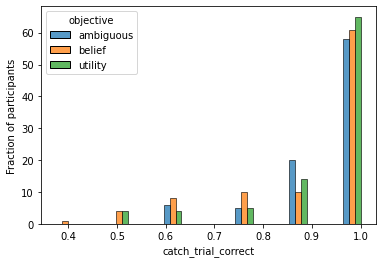

In [25]:
participant_catch_results = shared_trials[["catch_trial_correct", "objective", "workerid", "message_type"]].groupby(["workerid", "objective", "message_type"]).mean().reset_index()
participant_catch_results["passed_catch_trial"] = participant_catch_results.catch_trial_correct > .75

sns.histplot(participant_catch_results, x="catch_trial_correct", hue="objective", multiple="dodge")
plt.ylabel("Fraction of participants")

In [26]:
condition_catch_results = participant_catch_results.groupby("message_type")["passed_catch_trial"].agg([np.sum, np.size]).reset_index() 
condition_catch_results["pct_passed"] = condition_catch_results["sum"] / condition_catch_results["size"]
condition_catch_results["pct_passed"] = condition_catch_results["sum"] / condition_catch_results["size"]
print(condition_catch_results[["message_type", "sum"]])

  message_type  sum
0       slider  228


In [27]:
# Join catch results into main dataframe to simplify analysis
joined_trials = trials.set_index("workerid").join(participant_catch_results[["passed_catch_trial", "catch_trial_correct", "workerid"]].set_index('workerid')).reset_index()
joined_trials.passed_catch_trial = joined_trials.passed_catch_trial.astype(bool)
print("{} unique workers before join, {} after.".format(trials.workerid.nunique(), joined_trials.workerid.nunique()))

300 unique workers before join, 300 after.


In [28]:
conditions_quiz_catch = pd.merge(conditions_and_quiz, 
                                 participant_catch_results[["workerid", "passed_catch_trial"]], 
                                 left_on='workerid', right_on='workerid', how='left')

conditions_quiz_catch = conditions_quiz_catch.fillna(False)

conditions_quiz_catch.groupby(['objective', 'passed_quiz', 'passed_catch_trial']).size()

objective  passed_quiz  passed_catch_trial
ambiguous  False        False                 11
           True         False                 11
                        True                  78
belief     False        False                  9
           True         False                 23
                        True                  71
utility    False        False                  6
           True         False                 13
                        True                  79
dtype: int64

## Drop participants that did not pass

In [29]:
joined_trials = joined_trials[joined_trials.passed_catch_trial]

# Experiments 2 + 3: Slider Endorsements

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

slider_trials = joined_trials[joined_trials.trial_type == "html-slider-response"]

slider_trials["response"] = slider_trials.data.apply(lambda x: int(x["response"]))
slider_trials["feature"] = slider_trials.data.apply(lambda x: x["features"][0])
slider_trials["value"] = slider_trials.data.apply(lambda x: x["values"][0])
slider_trials["action_context"] = slider_trials.data.apply(lambda x: str([x["action_context"][0]]))

In [31]:
slider_trials.groupby(["objective", "horizon"]).workerid.nunique()

objective  horizon  
ambiguous  ambiguous    78
belief     ambiguous    71
utility    ambiguous    79
Name: workerid, dtype: int64

In [32]:
print("Should have 36 trials for all workers who passed catch trials and will be included in analyses:")
print(slider_trials.groupby('workerid').size().value_counts())

Should have 36 trials for all workers who passed catch trials and will be included in analyses:
36    228
dtype: int64


In [33]:
slider_trials.workerid.value_counts().value_counts()

36    228
Name: workerid, dtype: int64

In [ ]:
df = pd.DataFrame(json.load(open("exp2_all_trials_beta_one.json")))

df["feature"] = df.features.apply(lambda x: x[0])
df["value"] = df["values"].apply(lambda x: x[0])

df = df[["action_context", "reward_diff", "no_utterance_rewards", "truthful", "feature", "value"]]
df["string_summary"] = df.apply(lambda x: "{}:{}:{}".format(x["feature"], x["value"], x["action_context"]), axis=1)
df = df.set_index("string_summary")

slider_trials["string_summary"] = slider_trials.apply(lambda x: "{}:{}:{}".format(x["feature"], x["value"], x["action_context"]), axis=1)
slider_trials = slider_trials.set_index("string_summary")

slider_joined = slider_trials.join(df, how='left', rsuffix="_foo").reset_index()

## Add in "Expected Rewards"

In [36]:
slider_joined.groupby("horizon").workerid.nunique()

horizon
ambiguous    228
Name: workerid, dtype: int64

## Export Data for WebPPL

In [37]:
def extract_slider_trials(trial):
    
    jspsych_log_data = trial.get("data", {})
    action_context = jspsych_log_data.get("action_context")
    
    if not action_context:
        return None
    
    return {"action_context": action_context[0],
            "workerid": trial["workerid"],
            "objective": trial["objective"],
            "horizon": trial["horizon"],
            "response": trial["response"],
            "utterance": {"feature": trial["feature"], "feature_value": trial["value"]}}

def convert_slider_trial_to_endorsement(trial):
    
    jspsych_log_data = trial.get("data", {})
    action_context = jspsych_log_data.get("action_context")
    
    if not action_context:
        return None
    
    return {"action_context": action_context[0],
            "workerid": trial["workerid"],
            "objective": trial["objective"],
            "horizon": trial["horizon"],
            "response": 1 if trial["response"] > 50 else 0,
            "utterance": {"feature": trial["feature"], "feature_value": trial["value"]}}

#### By Condition

In [38]:
slider_joined_for_export = slider_joined[slider_joined.passed_catch_trial]

slider_trials_list = slider_joined_for_export.apply(lambda x: extract_slider_trials(x), axis=1)
slider_trials_list = list(slider_trials_list.dropna().values)

for condition in ['belief', 'utility', 'ambiguous']:
    
    for horizon in [1, 2, 4, 'ambiguous']:
    
        to_output = [x for x in slider_trials_list if x.get("objective") == condition]
        to_output = [x for x in to_output if x.get('horizon') == horizon]
        if to_output:
            with open(write_data_path + 'webppl-input/slider/O-{}-H-{}.json'.format(condition, horizon), 'w') as outfile:
                json.dump(to_output, outfile)

#### Individual workers

In [39]:
for workerid in slider_joined_for_export.workerid.unique():
    
    to_output = [x for x in slider_trials_list if x.get("workerid") == workerid]
    with open(write_data_path + 'webppl-input/slider/participants/{}.json'.format(workerid), 'w') as outfile:
        json.dump(to_output, outfile)

#### Multi-horizon in single file (Exp 3)

In [40]:
if experiment == 3:

    with open(write_data_path + 'webppl-input/slider/O-ambiguous-H-ALL.json', 'w') as outfile:
        json.dump(slider_trials_list, outfile)

#### Multi-objective in single file (Exp 2)

In [41]:
if experiment == 2:
    
    with open(write_data_path + 'webppl-input/slider/O-ALL-H-ambiguous.json', 'w') as outfile:
        json.dump(slider_trials_list, outfile)

## Read in WebPPL outputs

In [42]:
participant_mles = pd.read_json(open("experiment/webppl-exp2/participant_mles_via_gridsearch.json"))

In [43]:
slider_joined.workerid.nunique()

228

In [44]:
results_df = pd.DataFrame.from_dict(participant_mles).set_index("workerid")
results_df["truthWeight"] = 1 - results_df["utilityWeight"]
joined = slider_joined.set_index("workerid").join(results_df, how='inner').reset_index()
print("Joined in {} results.".format(joined.workerid.nunique()))

by_condition = joined.groupby("workerid")[["utilityWeight", "truthWeight", "objective", "alphaS", "horizon"]].sample(1).dropna()

Joined in 228 results.


In [45]:
by_condition.groupby(["objective", "horizon"]).size()

objective  horizon  
ambiguous  ambiguous    78
belief     ambiguous    71
utility    ambiguous    79
dtype: int64

In [46]:
from scipy.special import softmax

def prob_utterance(utilityWeight, alphaS, rewardDiff, truthful):
    
    this_utt_rewards = rewardDiff
    this_utt_truth = 1 if truthful else -1
    this_utt_utility = utilityWeight * this_utt_rewards + (1-utilityWeight) * this_utt_truth
    
    probs = softmax([this_utt_utility * alphaS, 0])
    
    return probs[0]

def model_predictions(utilityWeight, alphaS):
    
    utt_vector = np.linspace(-2, 2.5, 100)
    truthful = [prob_utterance(utilityWeight, alphaS, x, True) for x in utt_vector]
    false = [prob_utterance(utilityWeight, alphaS, x, False) for x in utt_vector]
    
    return utt_vector, truthful, false

ambiguous / ambiguous: 228 participants


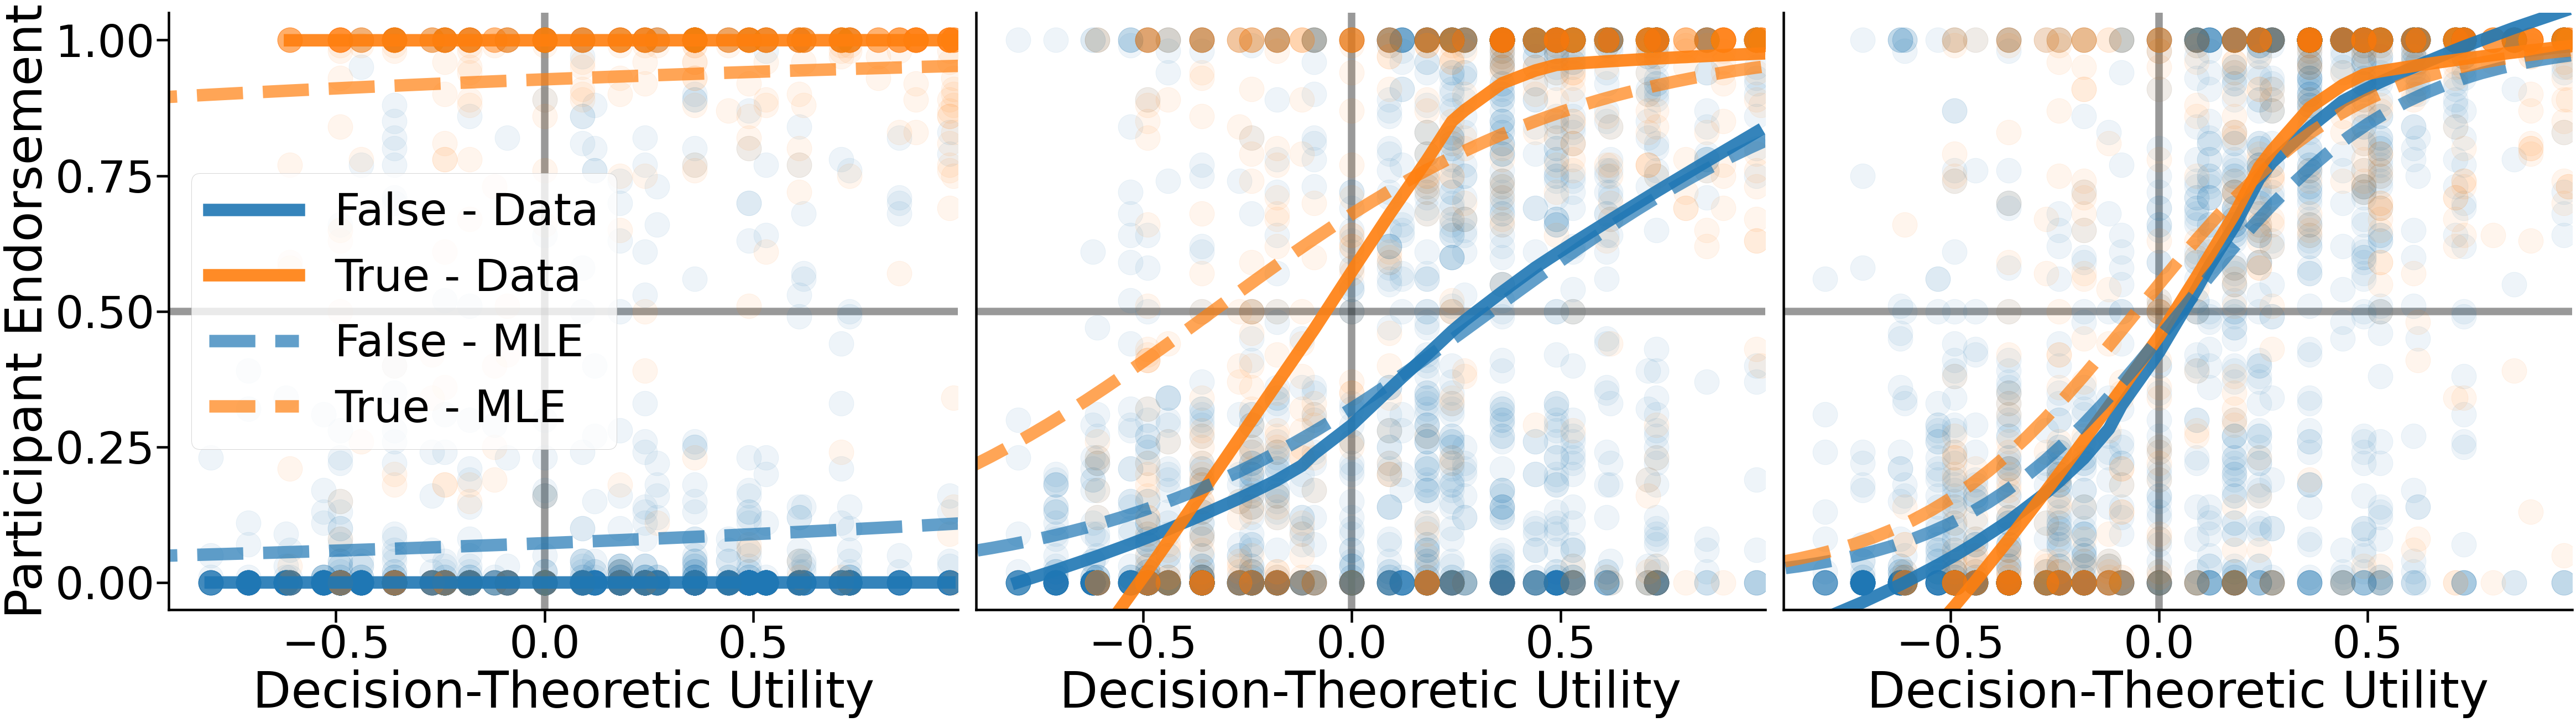

In [47]:
objective = "ambiguous"

if experiment == 2:
    params_to_plot = "objective"
    col_order = ["belief", "ambiguous", "utility"]

else:
    params_to_plot = "horizon"
    col_order = [1, 2, 4]

param_keys = {
    "utility": (.95, 4),
    # "utility": (0.90, 3),
    "ambiguous": (0.75, 3),
    "belief": (0.15, 3),
    
    1: (.7, 3),
    2: (0.6, 3),
    4: (0.65, 3),
}

to_plot = copy.deepcopy(slider_joined)

M = 4.5
    
to_plot["response"] = to_plot.response / 100


facet = sns.lmplot(data=to_plot, x="reward_diff", y="response", hue="truthful", scatter_kws={"alpha":.075, "s":2000}, 
                   col=params_to_plot, col_order=col_order, height=4*M, aspect=1.2, legend_out=False,
                   lowess=True, line_kws={"linewidth": 5*M, "alpha":.9}) 

facet._legend.remove()
for i, ax in enumerate(facet.axes[0]):

    utilityWeight, alphaS = param_keys[col_order[i]]
    utt_vector, truthful, false = model_predictions(utilityWeight, alphaS)
    ax.plot(utt_vector, false, label="False", linewidth=5*M, alpha=.7, linestyle='--')
    ax.plot(utt_vector, truthful, label="True", linewidth=5*M, alpha=.7, linestyle='--')

    ax.set_title("")

    ax.set_xlim(-.9, .99)
    ax.set_ylim(-.05, 1.05)
    ax.tick_params(labelsize=18*M, width=M, length=5*M)

    if i == 0:
        ax.legend(title='', loc='center left', labels=['False - Data', 'True - Data', 
                                                       'False - MLE', 'True - MLE'], 
                  fontsize=18*M)
        ax.set_yticks([0, .25, .5, .75, 1])

    else:
        ax.tick_params(labelsize=0, width=0, length=5*M, axis='y')
        
    [x.set_linewidth(M) for x in ax.spines.values()]
    ax.axvline(0, alpha=.4, color='k', linewidth=3*M, zorder=0)
    ax.axhline(.5, alpha=.4, color='k', linewidth=3*M, zorder=0)

facet.set_axis_labels("Decision-Theoretic Utility", "Participant Endorsement", fontsize=20*M)
facet.tight_layout()
        
plt.savefig(f'figures/exp{experiment}_endorsement_curves.pdf', dpi=300)
print("{} / {}: {} participants".format(objective, horizon, to_plot.workerid.nunique()))

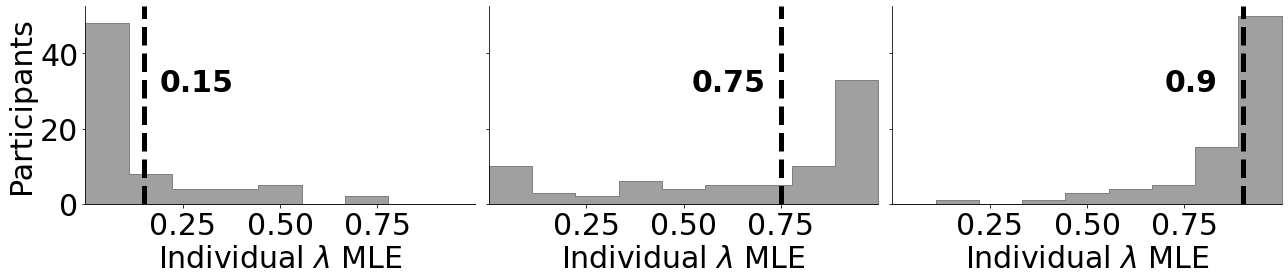

In [48]:
to_plot = by_condition

mles = {
    "utility": 0.90,
    "ambiguous": 0.75, 
    "belief": 0.15,
    1: .7,
    2: 0.6,
    4: 0.65, 
}

if experiment == 2:
    label_locs = [.19, .52, .7]
    col_order = ['belief', 'ambiguous', 'utility']
    text_height = 30

elif experiment == 3:
    label_locs = [.50, .40, .40]
    col_order = [1, 2, 4]
    text_height = 20

facet = sns.displot(to_plot, col=params_to_plot, col_order=col_order, x="utilityWeight", element="step",
                   height=4, aspect=1.5, color='gray')

for i, ax in enumerate(facet.axes[0]):

    ax.set_title("")

    ax.set_xlim(0, 1)
    ax.set_xticks([.25, .5, .75])
    ax.tick_params(labelsize=30)

    mle = mles[col_order[i]]
    ax.axvline(mle, linewidth=5, linestyle='--', c='k')
    ax.text(label_locs[i], text_height, "{}".format(mles[col_order[i]]), 
            fontdict={"size": 30, "weight": 'bold'})
    
    ax.set_xlabel("Individual $\lambda$ MLE", fontsize=30)

    if i == 0:
        ax.set_ylabel("Participants", fontsize=30) 

facet.tight_layout()
        
plt.savefig(f'figures/exp{experiment}_mle_estimates.pdf')
plt.show()